<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_4_imdb_reviews_with_GRU_LSTM_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Building Models for the IMDB Reviews Dataset

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

In [1]:
import tensorflow as tf

def set_tensorflow_config(per_process_gpu_memory_fraction=0.9):
    config = tf.compat.v1.ConfigProto()
    # config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = per_process_gpu_memory_fraction
    config.gpu_options.allow_growth=True
    # sess = tf.Session(config=config)
    sess = tf.compat.v1.Session(config=config)
    print("== TensorFlow Config options set ==")
    print("\nThis process will now utilize {} GPU Memeory Fraction".format(per_process_gpu_memory_fraction))

set_tensorflow_config()

2022-05-05 09:48:23.627065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 09:48:23.700966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:23.723018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:23.723426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

== TensorFlow Config options set ==

This process will now utilize 0.9 GPU Memeory Fraction


2022-05-05 09:48:24.684907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:24.685173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:24.685378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:24.685586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7184 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Imports

You will first import common libraries that will be used throughout the exercise.

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [3]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

2022-05-05 09:48:24.949226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:24.949519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:24.949701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:24.950041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 09:48:24.950241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [4]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

Unlike the subword encoded set you've been using in the previous labs, you will need to build the vocabulary from scratch and generate padded sequences. You already know how to do that with the `Tokenizer` class and `pad_sequences()` method.

In [5]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

## Plot Utility

Before you define the models, you will define the function below so you can easily visualize the accuracy and loss history after training.

In [6]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

*Note: You might see a different graph in the lectures. This is because we adjusted the `BATCH_SIZE` for training so subsequent models will train faster.*

In [7]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
 14/196 [=>............................] - ETA: 2s - loss: 0.6930 - accuracy: 0.5061

2022-05-05 09:48:37.697350: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 6s 19ms/step - loss: 0.6268 - accuracy: 0.6458 - val_loss: 0.4281 - val_accuracy: 0.8153
Epoch 2/10
196/196 [==============================] - 4s 18ms/step - loss: 0.3300 - accuracy: 0.8655 - val_loss: 0.3330 - val_accuracy: 0.8556
Epoch 3/10
196/196 [==============================] - 3s 17ms/step - loss: 0.2092 - accuracy: 0.9237 - val_loss: 0.3475 - val_accuracy: 0.8485
Epoch 4/10
196/196 [==============================] - 4s 19ms/step - loss: 0.1215 - accuracy: 0.9670 - val_loss: 0.3832 - val_accuracy: 0.8418
Epoch 5/10
196/196 [==============================] - 4s 19ms/step - loss: 0.0575 - accuracy: 0.9913 - val_loss: 0.4307 - val_accuracy: 0.8358
Epoch 6/10
196/196 [==============================] - 4s 19ms/step - loss: 0.0270 - accuracy: 0.9980 - val_loss: 0.4724 - val_accuracy: 0.8325
Epoch 7/10
196/196 [==============================] - 4s 19ms/step - loss: 0.0142 - accuracy: 0.9990 - val_loss: 0.5123 - val_accuracy: 0.8313
Epoch 8/10

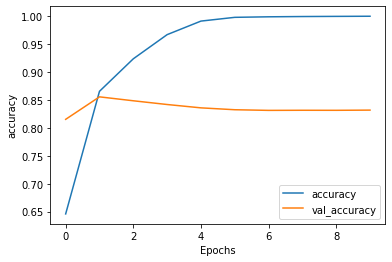

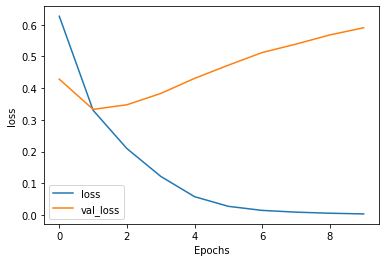

In [9]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [10]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [11]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2022-05-05 09:49:16.431812: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


196/196 [==============================] - 9s 34ms/step - loss: 0.5461 - accuracy: 0.6991 - val_loss: 0.3611 - val_accuracy: 0.8422
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 0.3096 - accuracy: 0.8740 - val_loss: 0.3680 - val_accuracy: 0.8382
Epoch 3/10
196/196 [==============================] - 6s 32ms/step - loss: 0.2490 - accuracy: 0.9027 - val_loss: 0.3729 - val_accuracy: 0.8459
Epoch 4/10
196/196 [==============================] - 6s 32ms/step - loss: 0.2074 - accuracy: 0.9230 - val_loss: 0.3950 - val_accuracy: 0.8346
Epoch 5/10
196/196 [==============================] - 6s 32ms/step - loss: 0.1824 - accuracy: 0.9326 - val_loss: 0.4269 - val_accuracy: 0.8312
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1441 - accuracy: 0.9516 - val_loss: 0.4642 - val_accuracy: 0.8290
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1241 - accuracy: 0.9586 - val_loss: 0.5086 - val_accuracy: 0.8266
Epoch 8/10

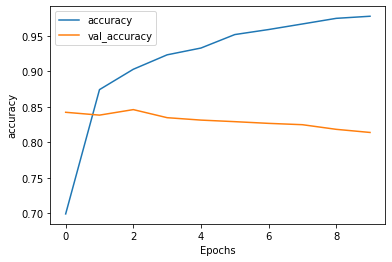

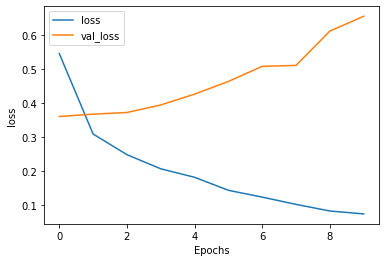

In [12]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [13]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [14]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 8s 32ms/step - loss: 0.5983 - accuracy: 0.6470 - val_loss: 0.3802 - val_accuracy: 0.8305
Epoch 2/10
196/196 [==============================] - 6s 31ms/step - loss: 0.3259 - accuracy: 0.8662 - val_loss: 0.3415 - val_accuracy: 0.8523
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.2474 - accuracy: 0.9053 - val_loss: 0.3712 - val_accuracy: 0.8439
Epoch 4/10
196/196 [==============================] - 6s 30ms/step - loss: 0.1981 - accuracy: 0.9282 - val_loss: 0.3938 - val_accuracy: 0.8389
Epoch 5/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1575 - accuracy: 0.9454 - val_loss: 0.4463 - val_accuracy: 0.8271
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1239 - accuracy: 0.9598 - val_loss: 0.4867 - val_accuracy: 0.8262
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 0.0997 - accuracy: 0.9661 - val_loss: 0.6412 - val_accuracy: 0.8118

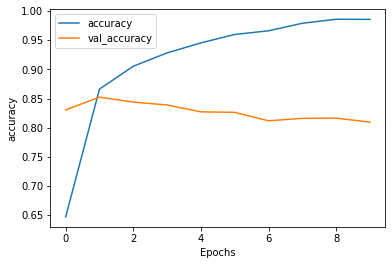

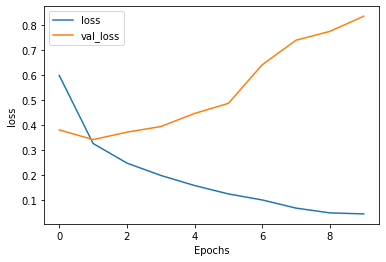

In [15]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [16]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [17]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2022-05-05 09:51:23.583865: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 4.00G (4294967296 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-05 09:51:23.584232: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 3.60G (3865470464 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-05 09:51:23.584562: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 3.24G (3478923264 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-05 09:51:23.584891: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 2.92G (3131030784 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-05 09:51:23.585185: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 2.62G (2817927680 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-05-05 09:51:23.585497: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 2.36

NotFoundError: Graph execution error:

Detected at node 'gradient_tape/sequential_3/conv1d/Conv1D/Conv2DBackpropInput' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_29798/1108414343.py", line 5, in <cell line: 5>
      history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/engine/training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "/home/acer/.virtualenvs/cv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_3/conv1d/Conv1D/Conv2DBackpropInput'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 25403408 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2470486016 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2470486016 bytes.
  Profiling failure on CUDNN engine 3#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 22069248 bytes.
  Profiling failure on CUDNN engine 3: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 22069248 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node gradient_tape/sequential_3/conv1d/Conv1D/Conv2DBackpropInput}}]] [Op:__inference_train_function_162976]

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.